# Nursery Scenario

In [1]:
from dependencies.NN import *
from dependencies.LTL import *
from dependencies.Utility_funcs import *

from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time
import os

2023-12-20 22:04:41.503745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Omega-automaton states (including the trap state): 55


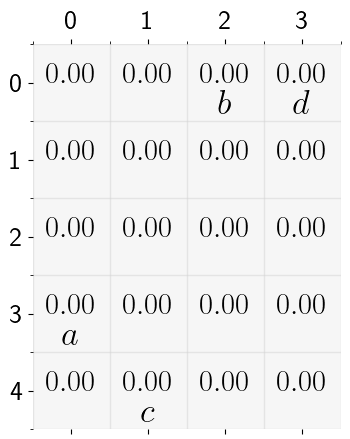

In [2]:
ltl = ('G ('
    '(!d) & '
    '(c->((!a) U b)) & '
    '((b & (X b))->(F a)) & '
    '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
    '(((!b) & (X b) & (!(X X b)))->((!a) U c)) &'
    '(a->(X ((!a) U b))) '
')')

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('b',),('d',)],
[(),    (),    (),    ()],
[(),    (),    (),    ()],
[('a',),(),    (),    ()],
[(),    ('c',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
} 
p = 0.8
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)
total_number_of_states = csrl.mdp.shape[0]*csrl.mdp.shape[1]*csrl.oa.shape[1]

In [3]:
csrl.shape, ch_states[(0,0,0,0)].shape, max_rew

((1, 55, 5, 4, 59), (55, 5, 4), 0.01)

In [10]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
# model.summary()

In [5]:
t = "[] ( (~d) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ ((~b /\ >b /\ ~>>b)->(~a % c)) )"

full_t = "[] ( (~d) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ (a -> >(~a % b))"
full_t += " /\ ((~b /\ >b /\ ~>>b)->(~a % c)) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) )"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)

In [11]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [12]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10
NN_value_active = False

search_depth = 400
MCTS_samples = 100

num_training_epochs =  30
num_test_epochs = 30
training = True
epochs = 10
T = [25, 50, 100, 200, 400]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []
acc_rew = []


# os.remove("outputs/Log_run.txt")
for i in T:
    # C , tow = Cs[idx % 3], tows[idx // 3]
    C , tow = 0.01, 0.1
    print("##########################")
    print("T:", i, "| C:",C, "| tow:",tow)
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,4,1)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=(4,1), search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0:
            train_wins+=1
        if any(reward_history): NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=(4,1), search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        acc_rew.append(reward_history)
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

##########################
T: 25 | C: 0.01 | tow: 0.1
[0. 0. 0. 0.] 0


KeyError: (0, 0, 4, 1)

In [ ]:
res = {25: 97, 2:3}

In [42]:
acc_1 = np.array([np.sum(i) for i in acc_rew_1]).reshape(4, 100)
acc_2 = np.array([np.sum(i) for i in acc_rew_2])

In [54]:
for i in np.array(acc_1):
    print((i[i>0]*100).mean(), np.sqrt(np.var((i[i>0]*100))))

1.0000000000000009 0.0
1.1016949152542383 0.3022466864428309
1.5625000000000013 0.9333240326917557
1.8787878787878802 1.1483209285755414


In [50]:
acc_2[acc_2>0]

array([0.01, 0.01, 0.03, 0.01, 0.03, 0.03, 0.01, 0.02, 0.01, 0.04, 0.01,
       0.02, 0.04, 0.01, 0.01, 0.02, 0.05, 0.01, 0.04, 0.01, 0.03, 0.04,
       0.02, 0.02, 0.03, 0.01, 0.06, 0.03, 0.02, 0.04, 0.03, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.03, 0.03, 0.04, 0.03, 0.04, 0.03, 0.02, 0.02,
       0.02, 0.02, 0.01, 0.02, 0.01, 0.02, 0.02, 0.03, 0.04, 0.01, 0.01,
       0.01])

In [46]:
import pickle 
# with open('acc_rew.pkl', 'wb') as f:
#     pickle.dump(acc_rew, f)

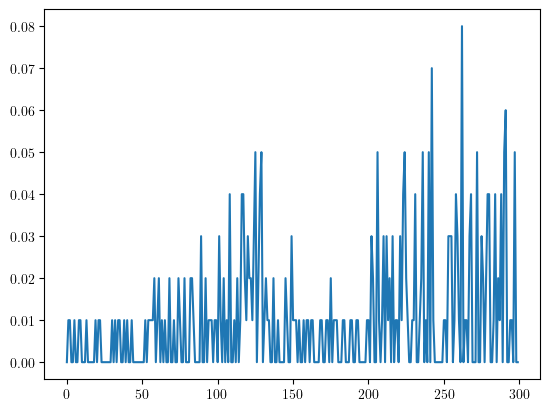

In [18]:
plt.plot([np.sum(i) for i in acc_rew[:800]])

In [11]:
# model.save_weights(f'models/p=1/Nurseryp1')

exploration in training: 0.02
exploration in testing: 0.01


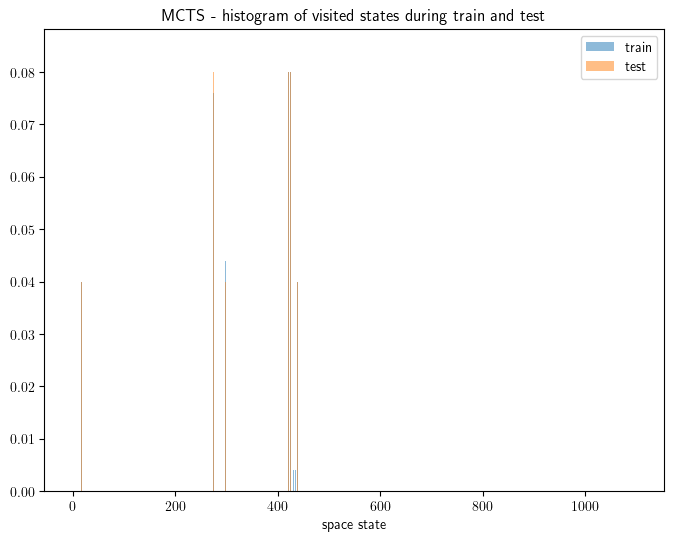

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(encode_visited_states_train, bins=range(total_number_of_states), density=True, alpha=0.5, label="train")
plt.title("MCTS - histogram of visited states during train and test")
plt.xlabel("space state")

plt.hist(encode_visited_states_test, bins=range(total_number_of_states), density=True, alpha=0.5, label="test")
plt.legend()

print("exploration in training:", round(np.unique(encode_visited_states_train).shape[0]/total_number_of_states, 2))
print("exploration in testing:", round(np.unique(encode_visited_states_test).shape[0]/total_number_of_states, 2))

[100.0]

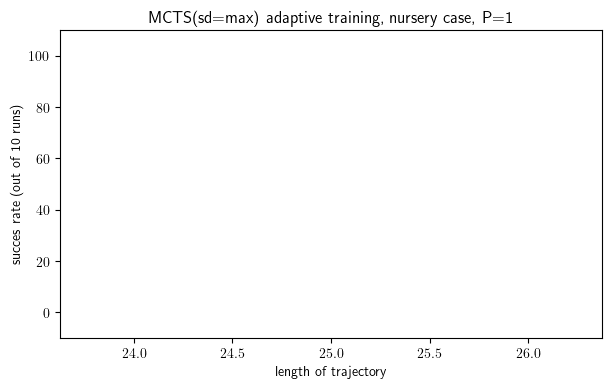

In [ ]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.ylim(-10, 110)
plt.xlabel("length of trajectory")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS(sd=max) adaptive training, nursery case, P="+str(p))
success_rates

Text(0.5, 1.0, 'training loss')

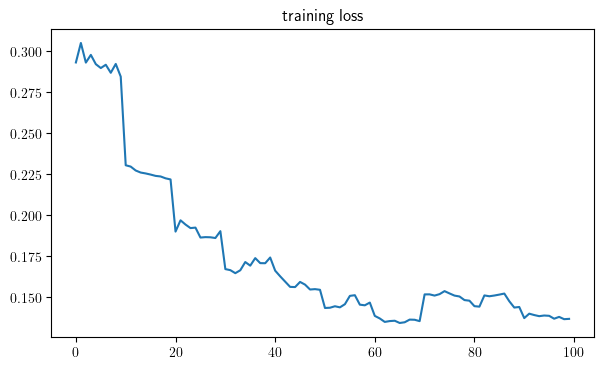

In [ ]:
interval = 400
plt.figure(figsize=(7,4))
plt.plot(train_history)
plt.title("training loss")
# plt.xticks(range(1,num_training_epochs*epochs,interval), range(0,num_training_epochs,interval//epochs));

In [26]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')

t=IntSlider(value=0,min=0,max=T[-1]-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=299), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_agent(t)>

In [56]:
Q = np.load(f'Q2_{p}.npy')

In [55]:
p

0.8

In [86]:
Q, visited_states =csrl.q_learning(T=100,K=100000, start=(4,1))
np.save(f'Q2_{p}.npy', Q)

# encode_visited_states = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states]

In [61]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

CSRL exploration in training: 0.34


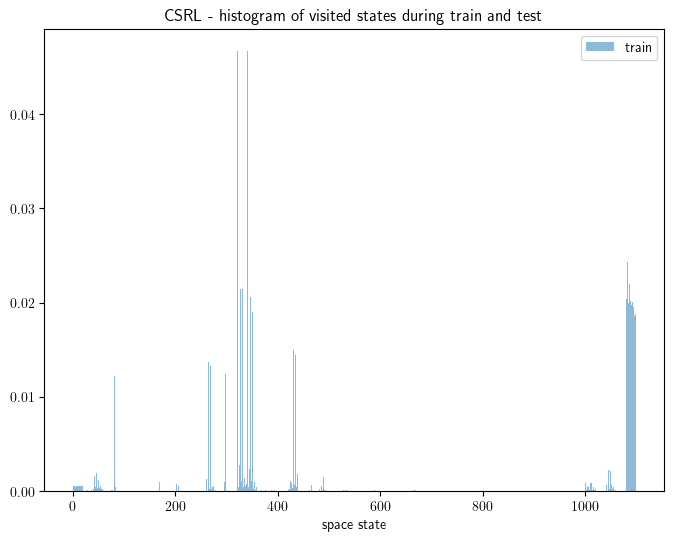

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(encode_visited_states, bins=range(total_number_of_states), density=True, alpha=0.5, label="train")
plt.title("CSRL - histogram of visited states during train and test")
plt.xlabel("space state")

plt.legend()

print("CSRL exploration in training:", round(np.unique(encode_visited_states).shape[0]/total_number_of_states, 2))

In [87]:
episode, rew =csrl.simulate(policy, LTL_formula, predicates, start=(4,1),T=100,plot=True)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

In [72]:
rewards_mean = []
rewards_std = []
n_runs = 100

T = [25, 50, 100, 200, 400]

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=(4,1), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 25 time-steps...
Test finished with:
	success rate: 0.3600000000000003 / 100 = 0.004
Running 100 simulations with 50 time-steps...
Test finished with:
	success rate: 1.5200000000000014 / 100 = 0.015
Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 4.300000000000004 / 100 = 0.043
Running 100 simulations with 200 time-steps...
Test finished with:
	success rate: 9.300000000000008 / 100 = 0.093
Running 100 simulations with 400 time-steps...
Test finished with:
	success rate: 19.450000000000017 / 100 = 0.195


In [84]:
print(np.sum(rew*100, 1).mean(), np.sqrt(np.sum(rew*100, 1)))

0.19450000000000017 [0.45825757 0.42426407 0.42426407 ... 0.4472136  0.4472136  0.45825757]


Text(0.5, 1.0, 'CSRL performance results on the nursery case, P=0.8')

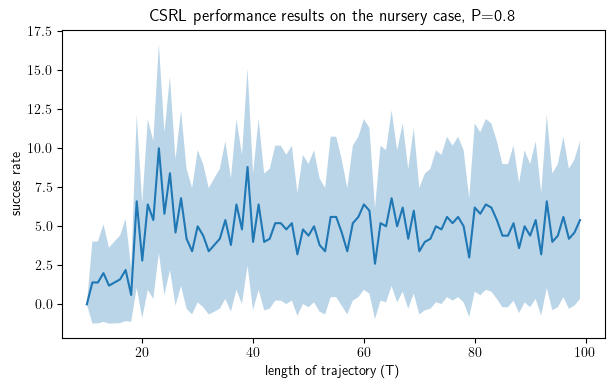

In [14]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("CSRL performance results on the nursery case, P="+str(p))

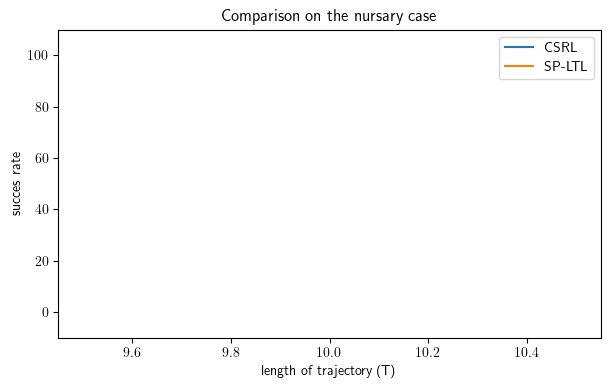

In [ ]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the nursary case")
# plt.title("Comparison on the nursary case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()
plt.savefig(f"res_400/C2_P{p}.pdf")